In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image

from collections import Counter
from tqdm import tqdm

In [2]:
anno_path = 'dataset/digital_digit/anno_digit.txt'

In [6]:
def padding(img, boxes, constant_values = 144, pad_type = 'constant'):
    img = np.array(img)
    h, w, _ = img.shape
    boxes = boxes * [w, h, w, h]
    gap = abs(w - h) // 2
    if w > h:
        reshape_img = np.pad(img, ((gap, gap), (0, 0), (0,0)), pad_type, constant_values=constant_values)
        # boxes = boxes + [0, gap, 0, gap]
        h = h + (gap*2)
    else:
        reshape_img = np.pad(img, ((0, 0), (gap, gap), (0,0)), pad_type, constant_values=constant_values)
        # boxes = boxes + [gap, 0, gap, 0]
        w = w + (gap*2)

    # boxes = boxes * [w, h, w, h]
    return img, boxes

In [15]:
reshape_img.shape

NameError: name 'reshape_img' is not defined

In [16]:
plt.imshow(reshape_img)

NameError: name 'reshape_img' is not defined

In [5]:
from dataset import VOCDataset
from anchor import generate_default_boxes
import yaml

In [6]:
with open('config.yml') as f:
    cfg = yaml.load(f, Loader=yaml.Loader)
    config = cfg['SSD300']
    
default_boxes = generate_default_boxes(config)

In [7]:
data_anno_path = '../../../dataset/digital_digit/anno_digit.txt'
dataset = VOCDataset(data_anno_path, default_boxes, 300, -1, labels = ['0','1','2','3','4','5','6','7','8','9','.'])

In [16]:
for d in dataset.generate():
    break

In [17]:
d

('../../../dataset/digital_digit/images/clock38.jpg',
 <tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
 array([[[ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         ...,
         [-0.4015748 , -0.32283467, -0.27559054],
         [-0.25984251, -0.1574803 , -0.0944882 ],
         [-0.17322832, -0.07086617,  0.00787401]],
 
        [[ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         ...,
         [-0.37795275, -0.29133856, -0.23622048],
         [-0.23622048, -0.14173228, -0.06299216],
         [-0.1889764 , -0.07874018,  0.00787401]],
 
        [[ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         [ 0.13385832,  0.13385832,  0.13385832],
         ...,
         [-0.3464567 , -0.2519685 , -0.21259844],
         [-0.20472443, -0.11023623, -0.031

In [18]:
boxes = decode(default_boxes, d[3])

In [19]:
cord = boxes[0] * [300, 300, 300, 300]

In [20]:
cord = cord.numpy().astype(dtype=np.int)

In [21]:
img = d[1]

In [22]:
output_img = cv2.rectangle(img.numpy(), (cord[0], cord[1]), (cord[2], cord[3]), (0,0,255), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


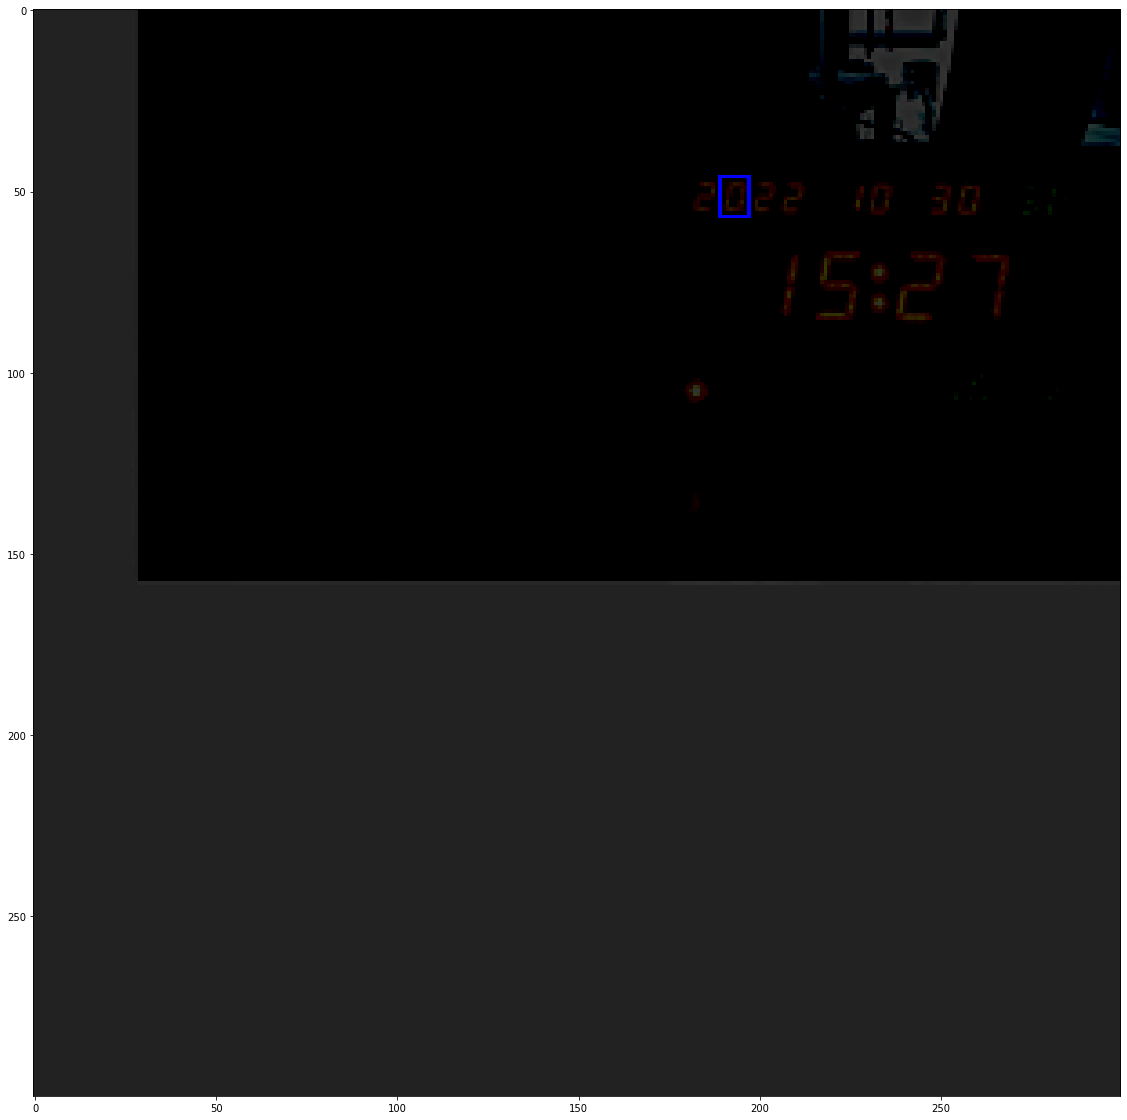

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(output_img)

In [60]:
!python3 dataset.py

2022-11-17 08:10:41.422063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 08:10:41.861287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 88 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
Traceback (most recent call last):
  File "dataset.py", line 223, in <module>
    dataset = VOCDataset(data_anno_path, default_boxes, image_size, -1, idx_to_idx = labels)
TypeError: __init__() got an unexpected keyword argument 'idx_to_idx'


In [79]:
from network import create_ssd
from anchor import generate_default_boxes
from image_utils import padding, ImageVisualizer
from box_utils import decode, compute_nms

import tensorflow as tf
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

labels = ['0','1','2','3','4','5','6','7','8','9', '.']
num_classes = len(labels) + 1 
IMAGE_SIZE = 300

model = create_ssd(num_classes=num_classes, arch='ssd300', pretrained_type=None, checkpoint_path='/home/workspace/iot_ai_model/check_points/ssd-digit/ssd_epoch_latest.h5')
visualizer = ImageVisualizer(labels, save_dir='.')
config = {}
config['scales'] =  [0.07, 0.2, 0.375, 0.55, 0.725, 0.9, 1.075]
config['fm_sizes'] = [38, 19, 10, 5, 3, 1]
config['ratios'] = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
default_boxes = generate_default_boxes(config)

def detect(model, image_path):
    org_img = Image.open(image_path).convert('RGB')
    org_img, _ = padding(org_img)
    img = np.array(org_img.resize((IMAGE_SIZE, IMAGE_SIZE)), dtype=np.float32)
    img = (img / 127.0) - 1.0
    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    confs, locs = model(img)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(img[0] +0.6)
    
    confs = tf.squeeze(confs, 0)
    locs = tf.squeeze(locs, 0)

    confs = tf.math.softmax(confs, axis=-1)
    classes = tf.math.argmax(confs, axis=-1)
    scores = tf.math.reduce_max(confs, axis=-1)
    boxes = decode(default_boxes, locs)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, num_classes):
        cls_scores = confs[:, c]

        score_idx = cls_scores > 0.2

        # print((c-1), max(cls_scores))
        # cls_boxes = tf.boolean_mask(boxes, score_idx)
        # cls_scores = tf.boolean_mask(cls_scores, score_idx)
        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, 0.1, 200)
        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)
        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()
    
    boxes *= org_img.size * 2
    boxes = boxes.astype(dtype=np.int16)
    
    # visualizer.save_image(org_img, boxes, classes, '{:d}'.format(0))
    
    plt.figure(figsize=(20, 20))
    visualizer.plt_image(org_img, boxes, classes, '{:d}'.format(0))
    

loaded weight /home/workspace/iot_ai_model/check_points/ssd-digit/ssd_epoch_latest.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


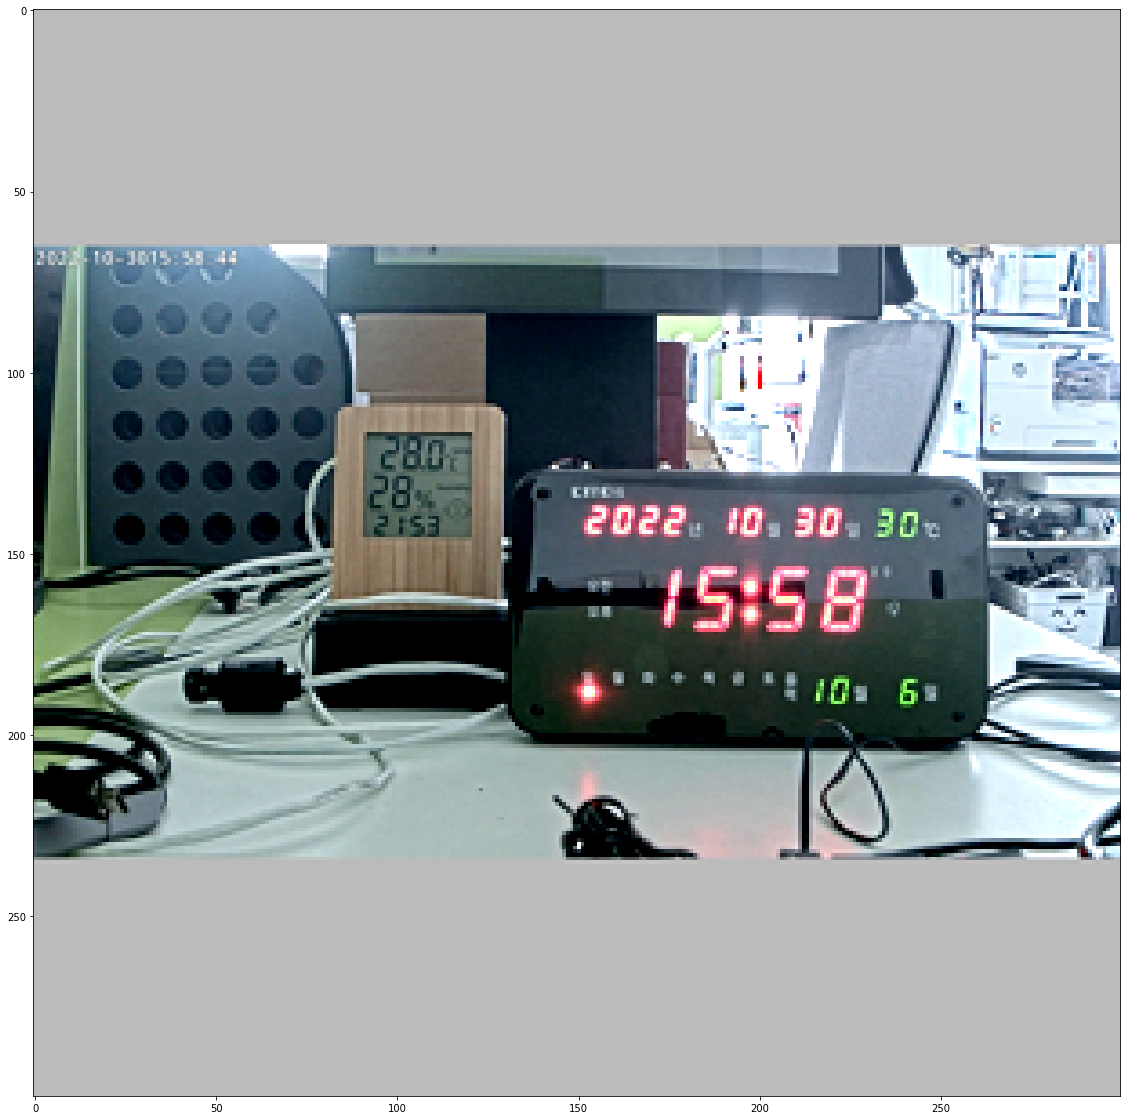

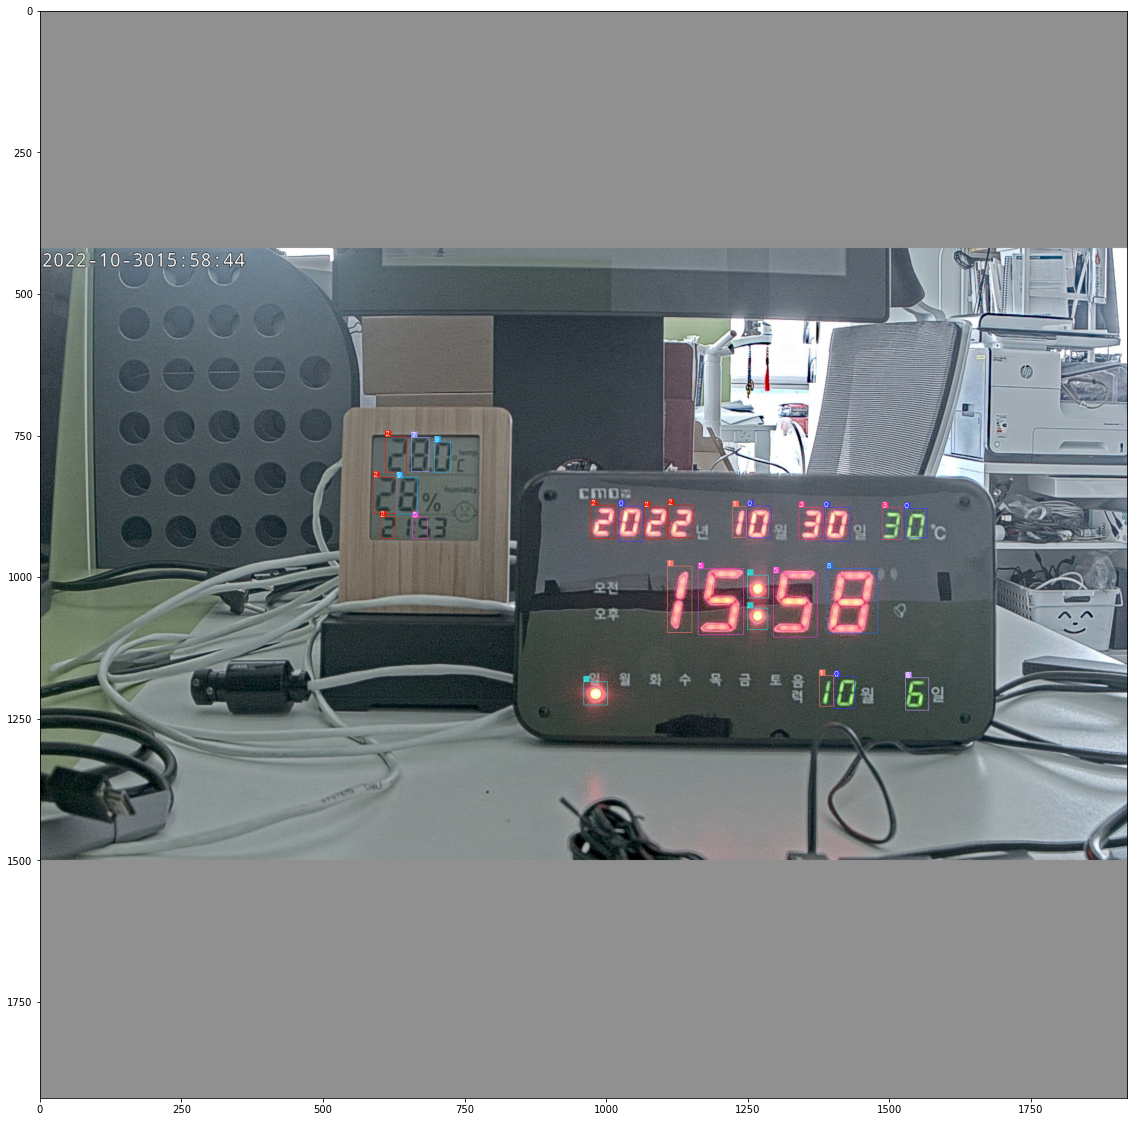

In [81]:
detect(model, '/home/workspace/iot_ai_model/dataset/digital_digit/images/clock18.jpg')